In [2]:
# Read file which has format:
# {"params": "{'ds': 'two-circles', 'n': 1000, 'eps': 0.2, 'k': 2}", "result": {"gen_time": 0.0011019706726074219, "coreset_time": 3.4044859409332275, "coreset_size": 1000, "kmeans_time": 0.0034589767456054688, "kmeans_rounds": 24, "precision": 0.998, "recall": 0.997996000016032, "fmeasure": 0.997998000004008, "rand": 0.998, "jaccard": 0.996004}}

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Each line is stored as:
# file.write(f"{params}: {result}\n")

# df = pd.read_csv("results.csv", sep=",")
    
# df.head()

C:\Users\lucas\AppData\Local\Temp\ipykernel_4656\1774447855.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


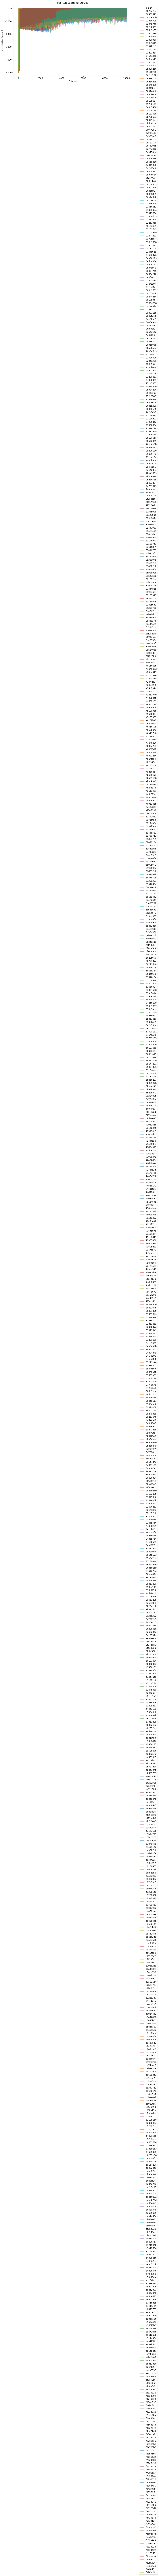

In [4]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 2) Plot each run_id as a separate line
plt.figure(figsize=(10, 6))
for run_id, run_df in df.groupby('run_id'):
    plt.plot(
        run_df['episode'],
        run_df['cumulative_reward'],
        label=str(run_id)[:8],  # truncate for readability
        alpha=0.5
    )
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Per-Run Learning Curves')
plt.legend(title='Run ID', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


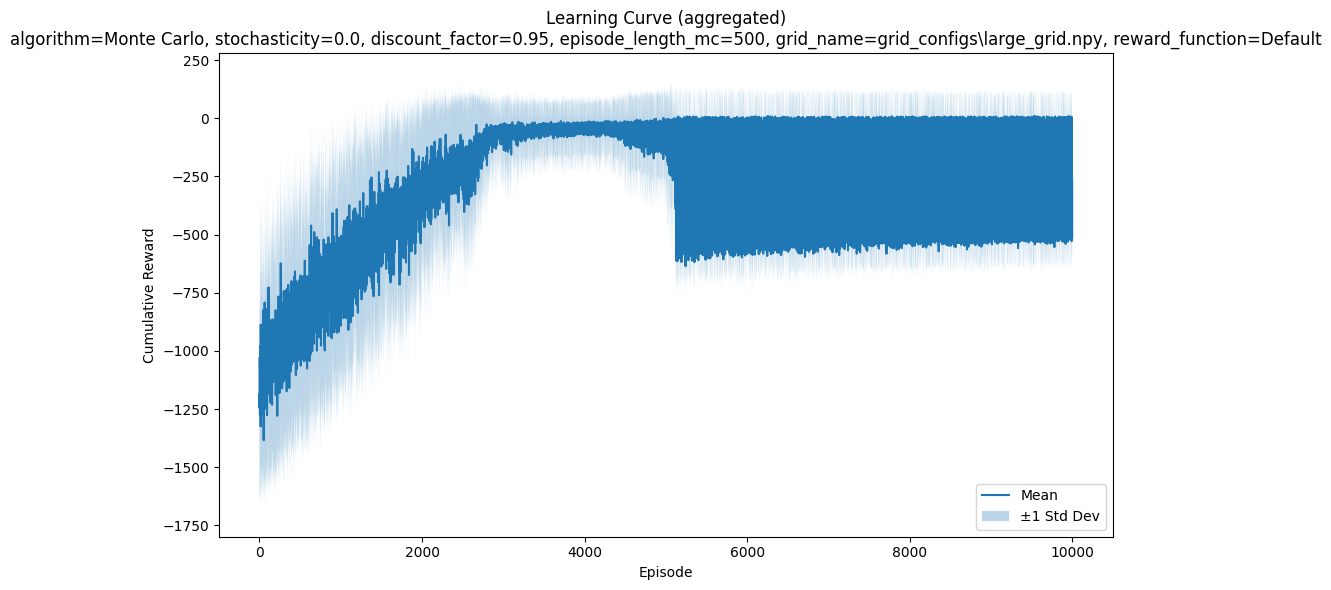

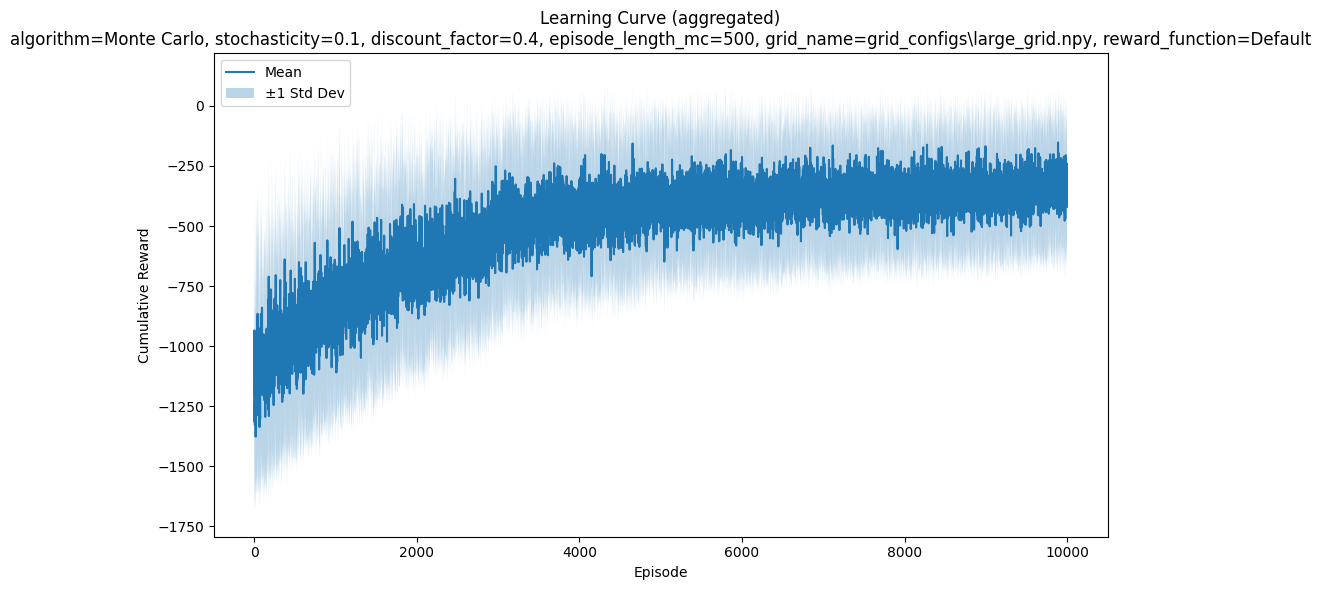

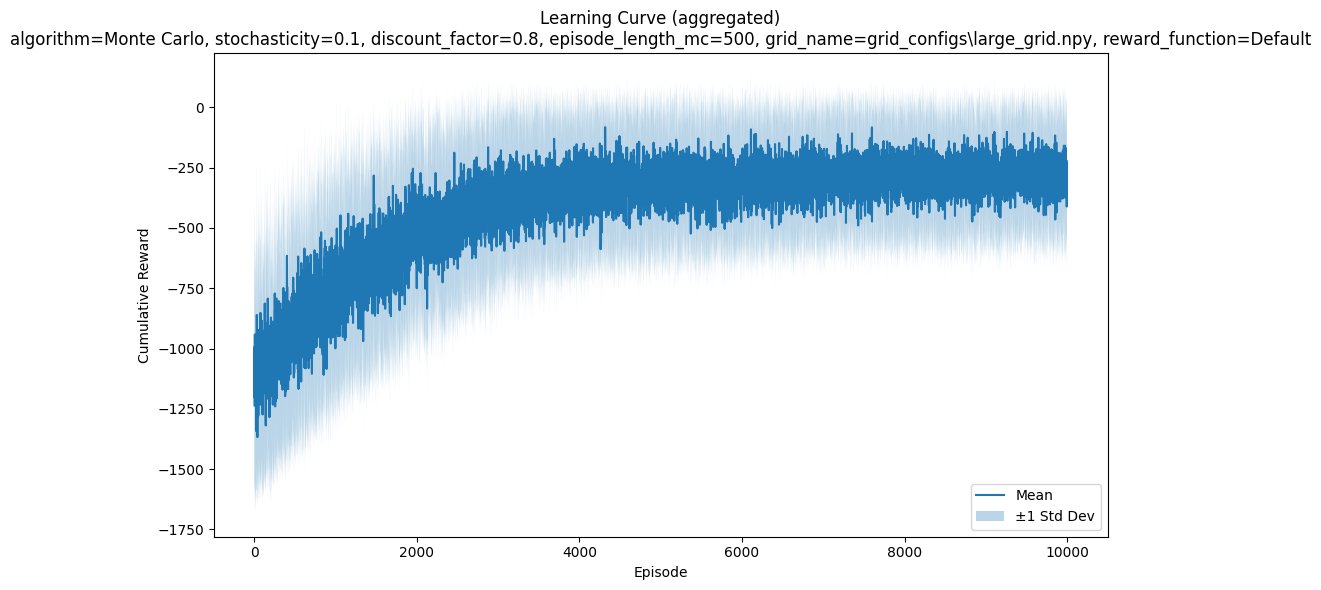

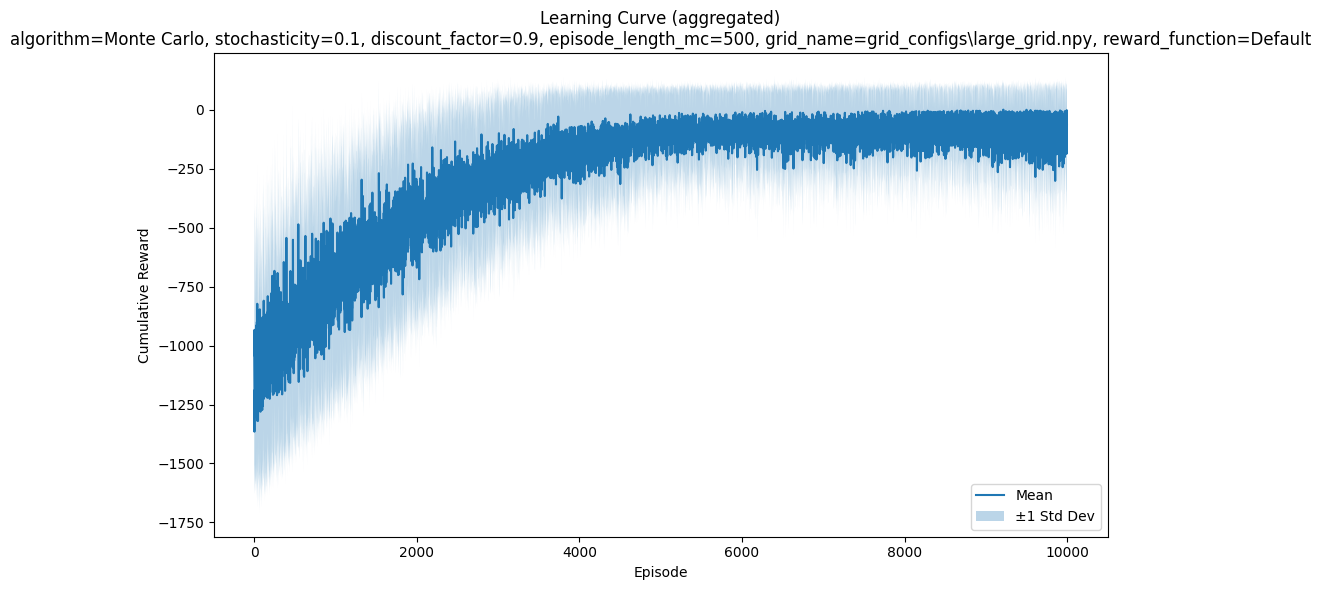

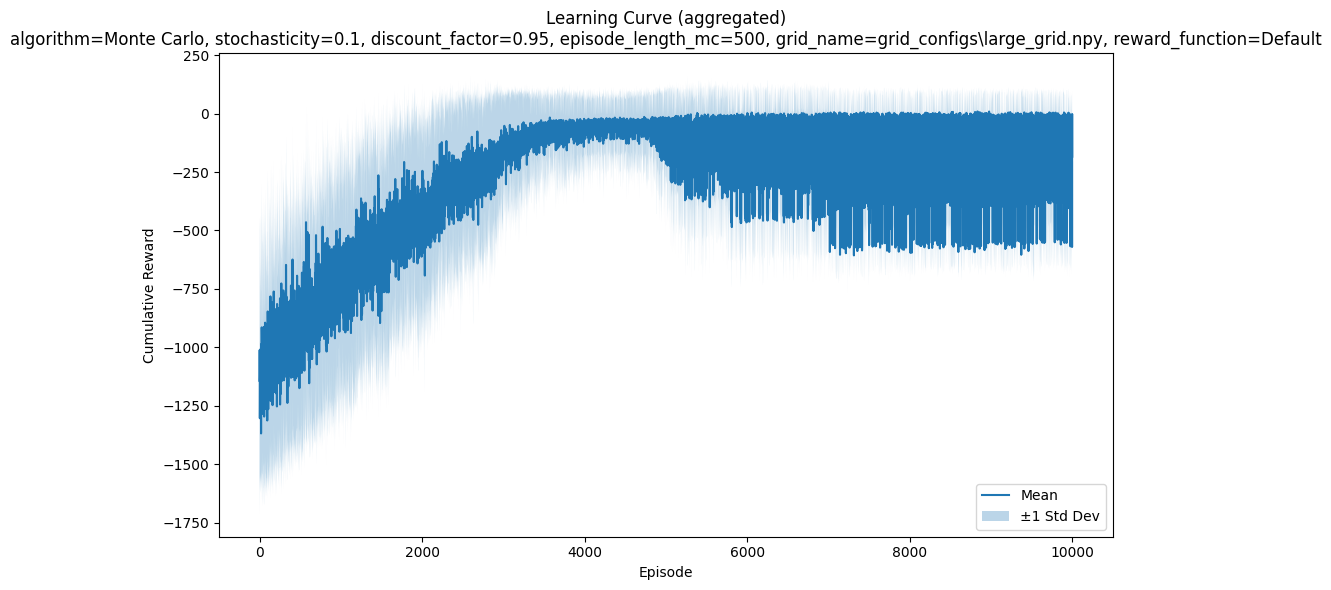

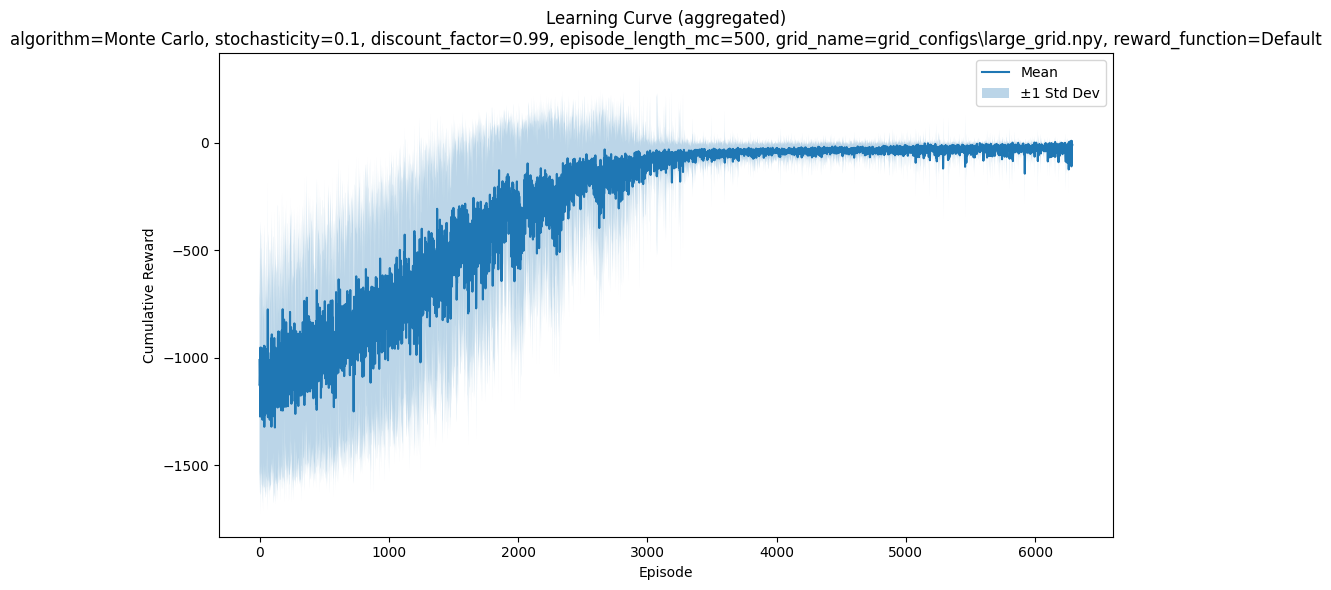

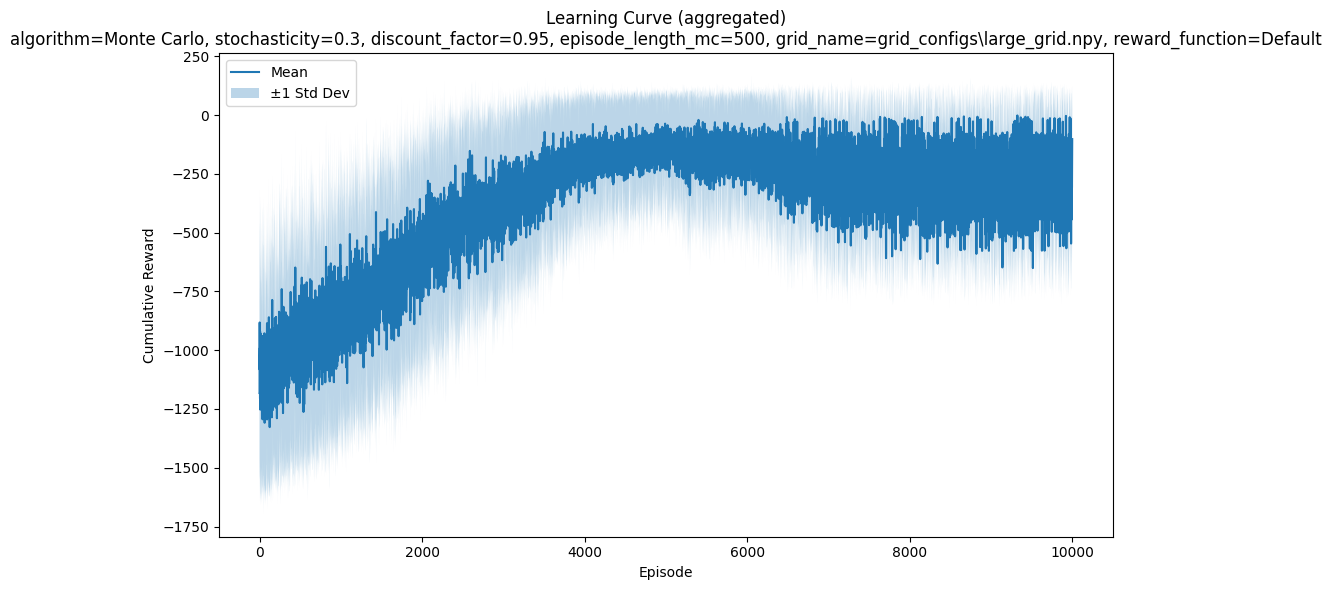

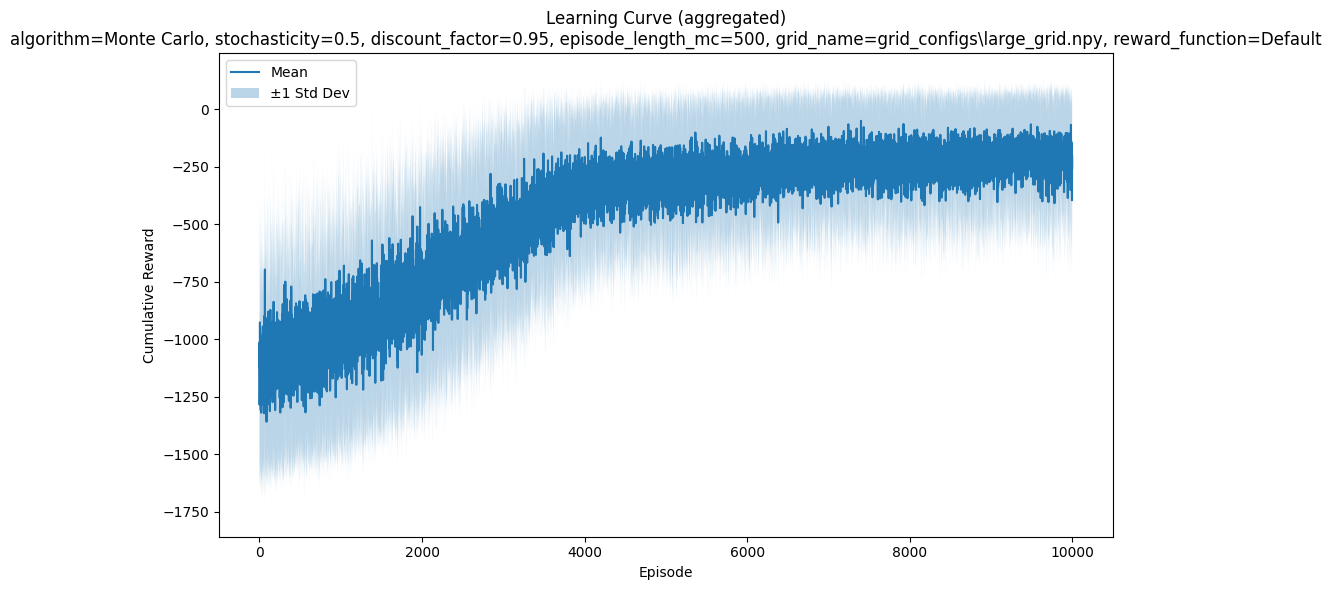

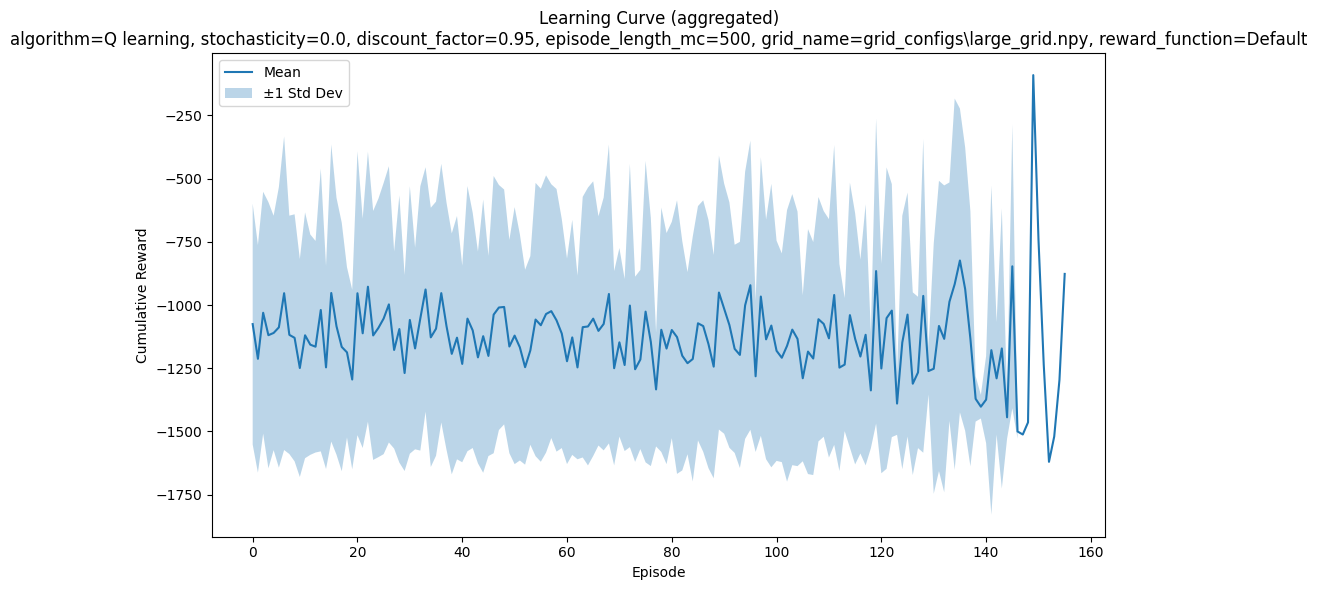

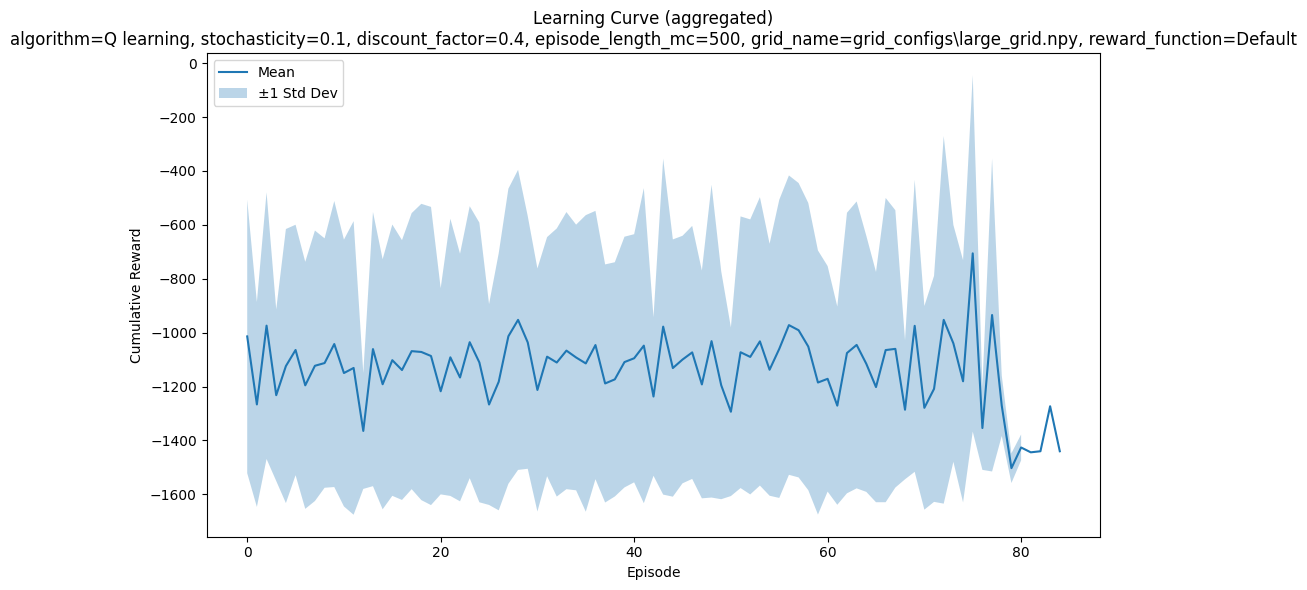

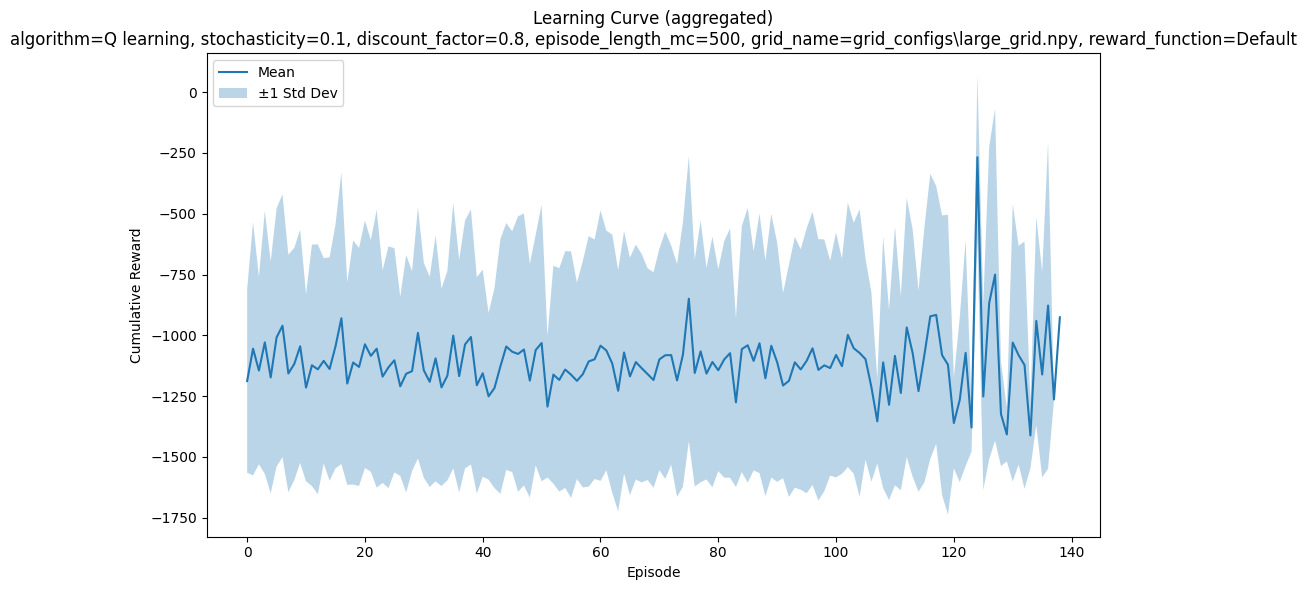

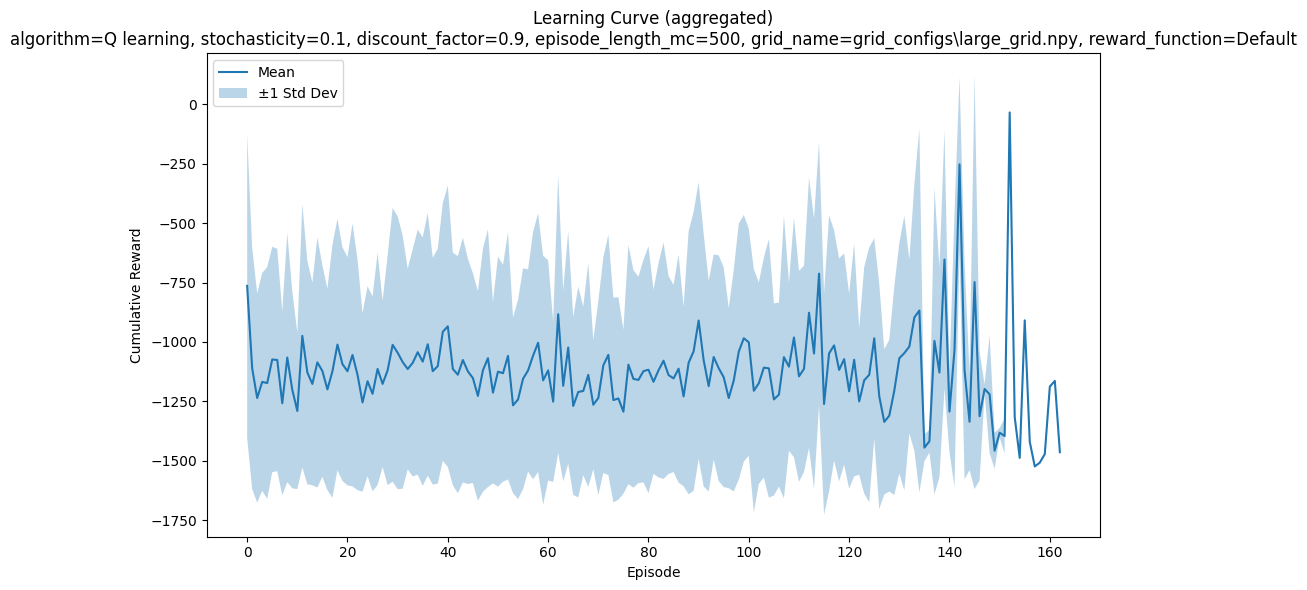

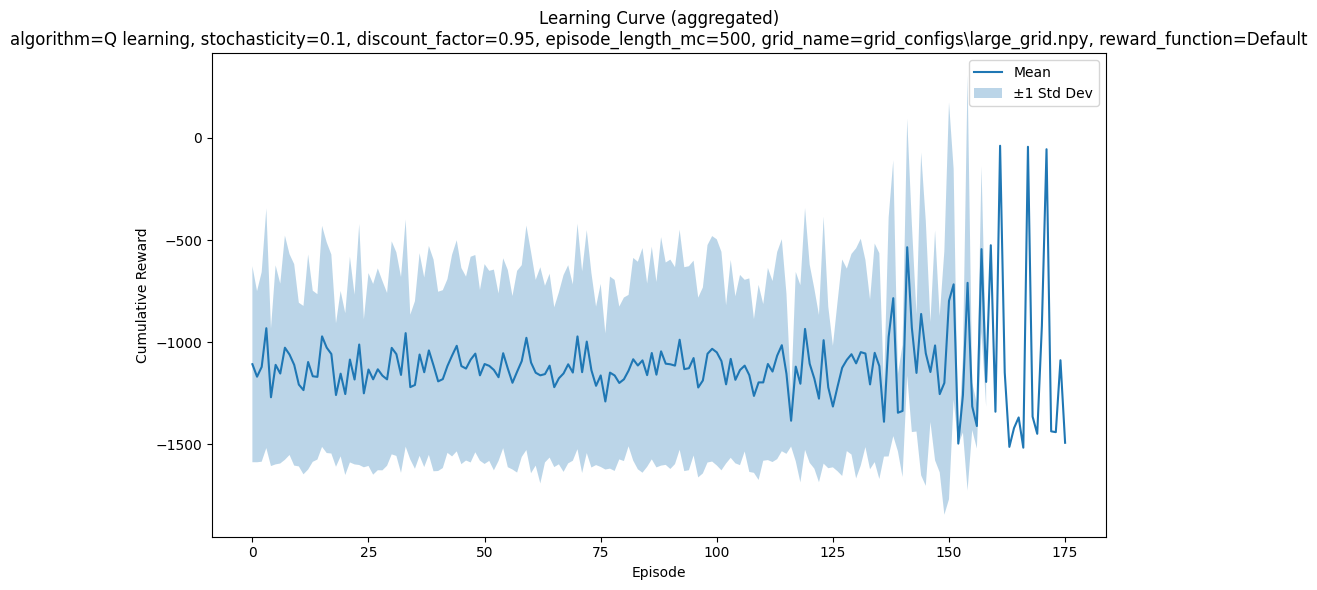

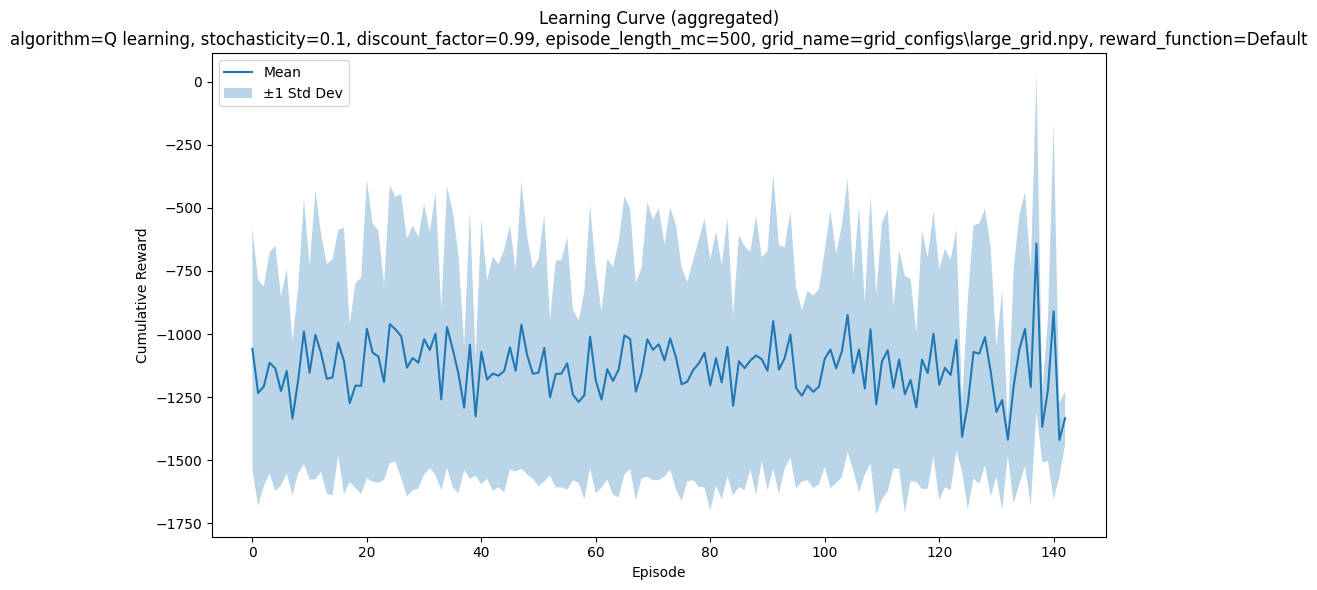

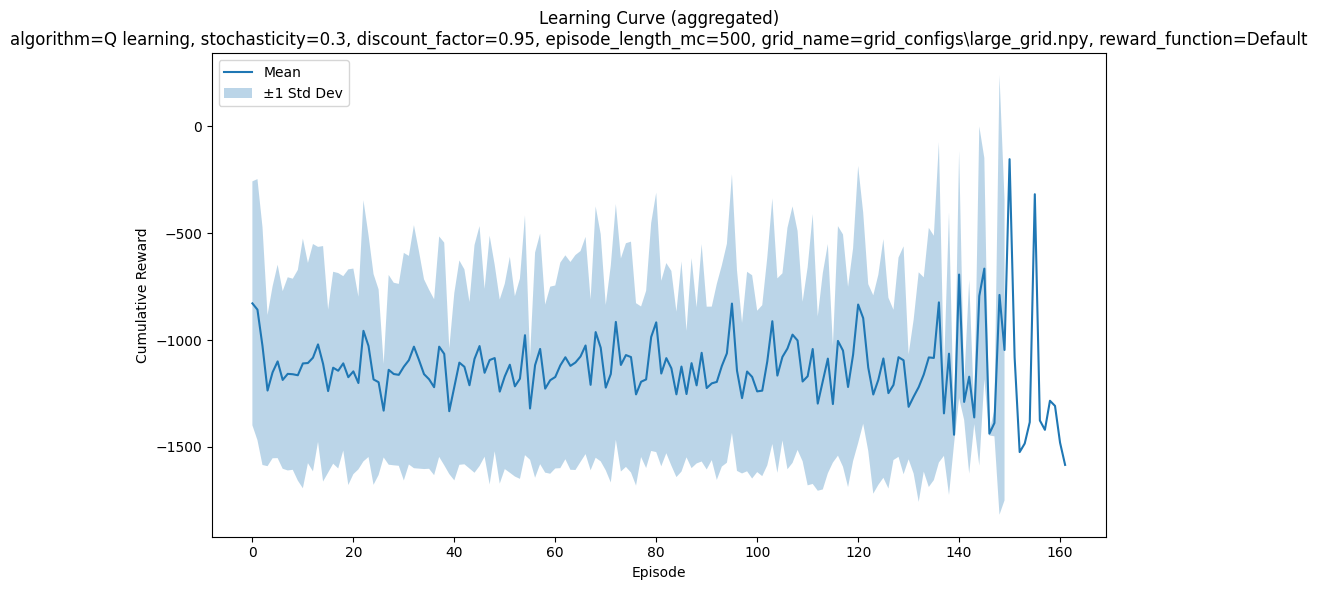

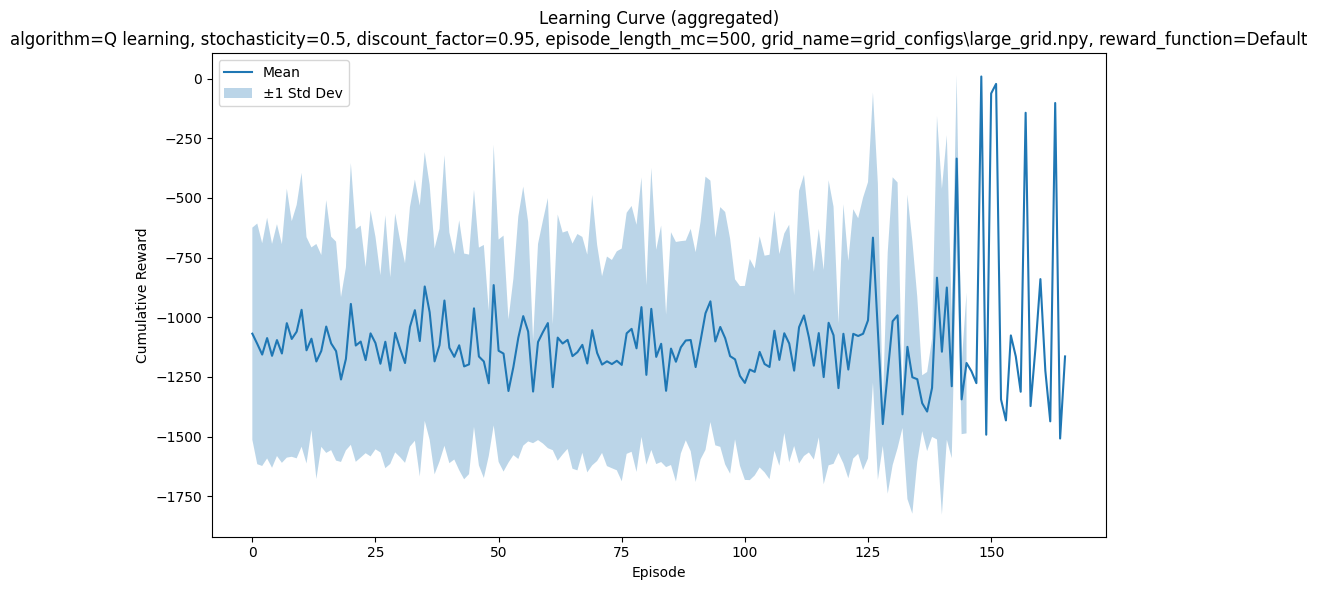

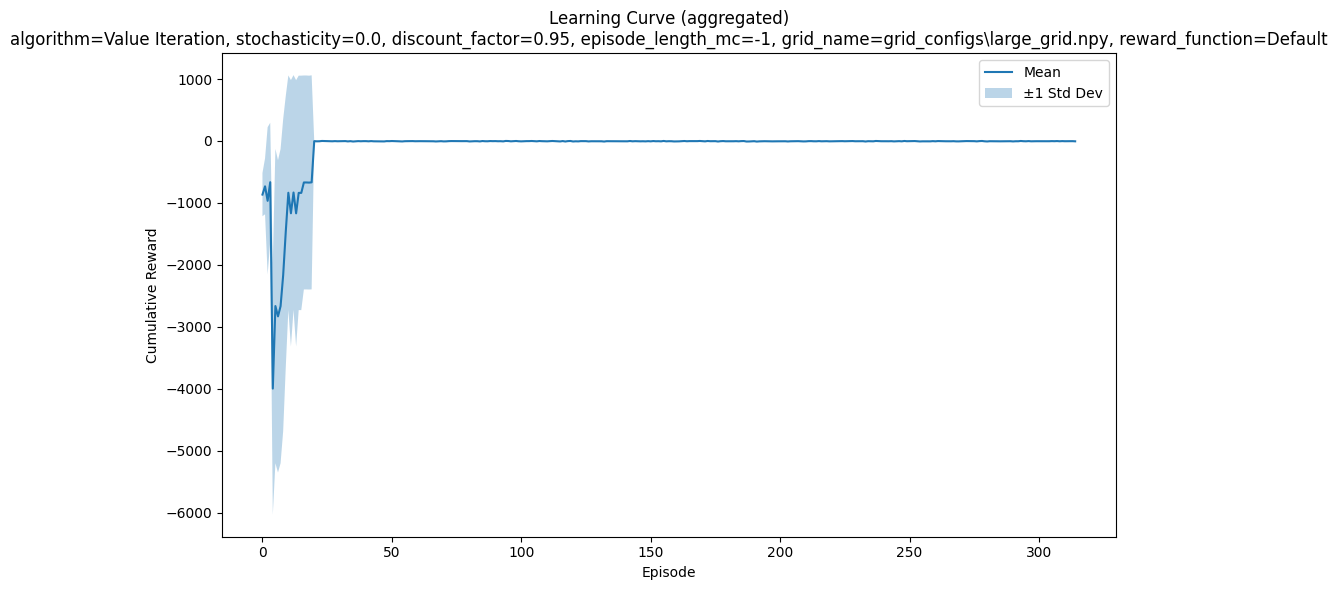

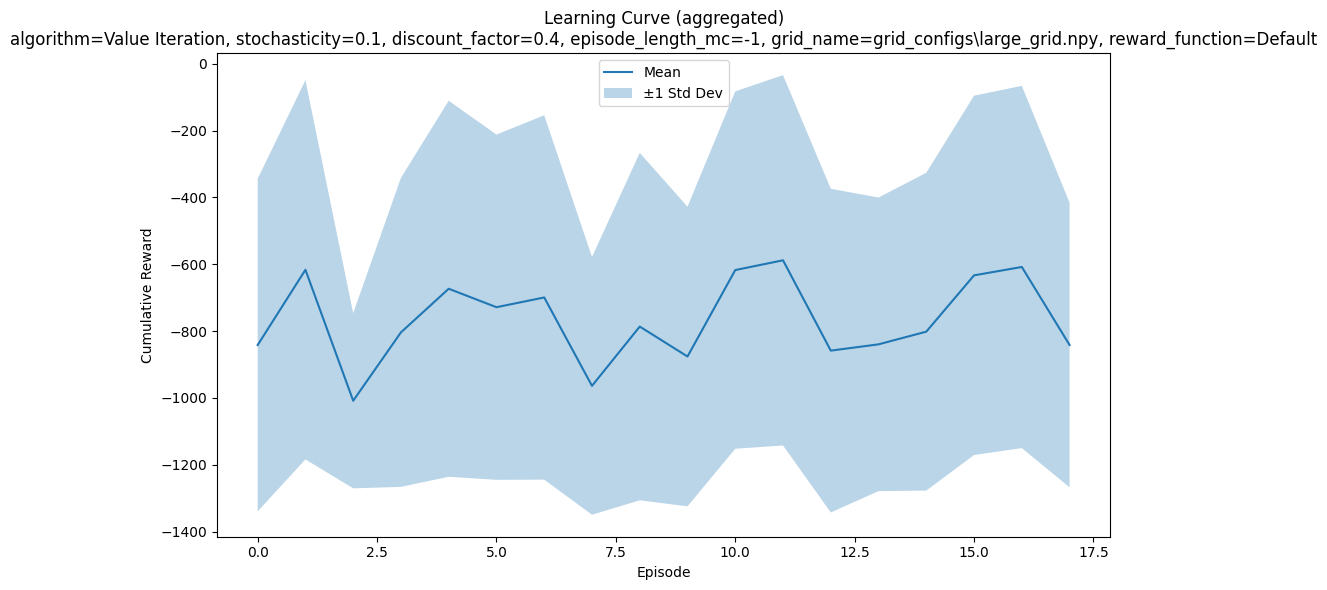

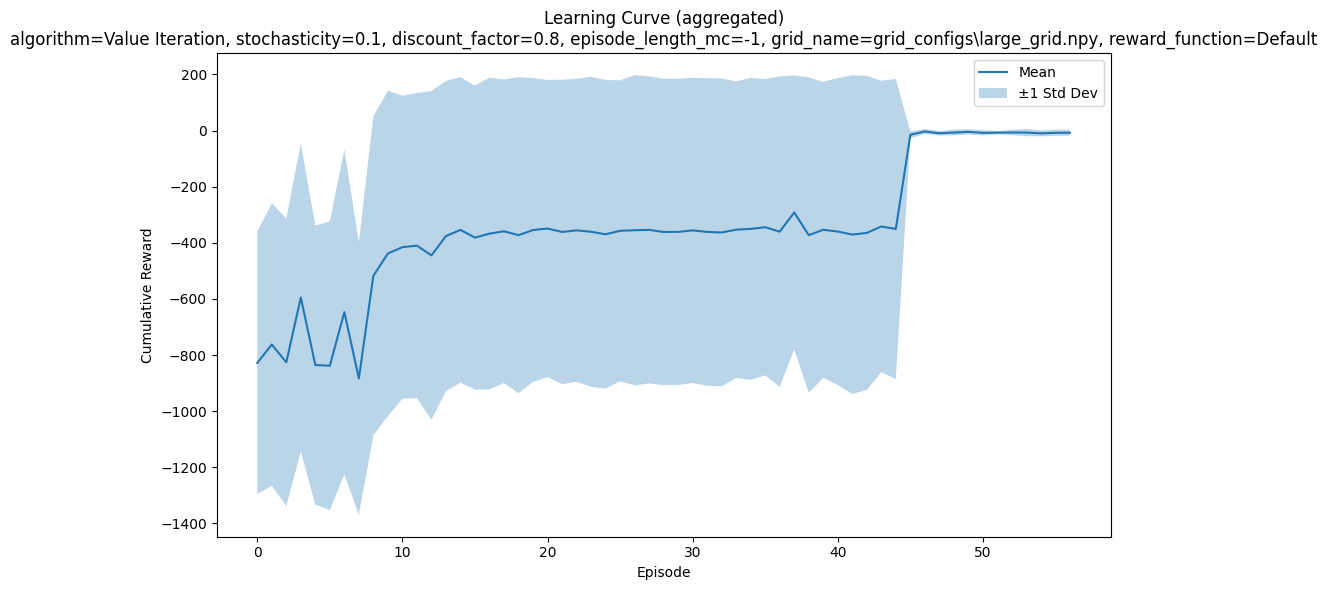

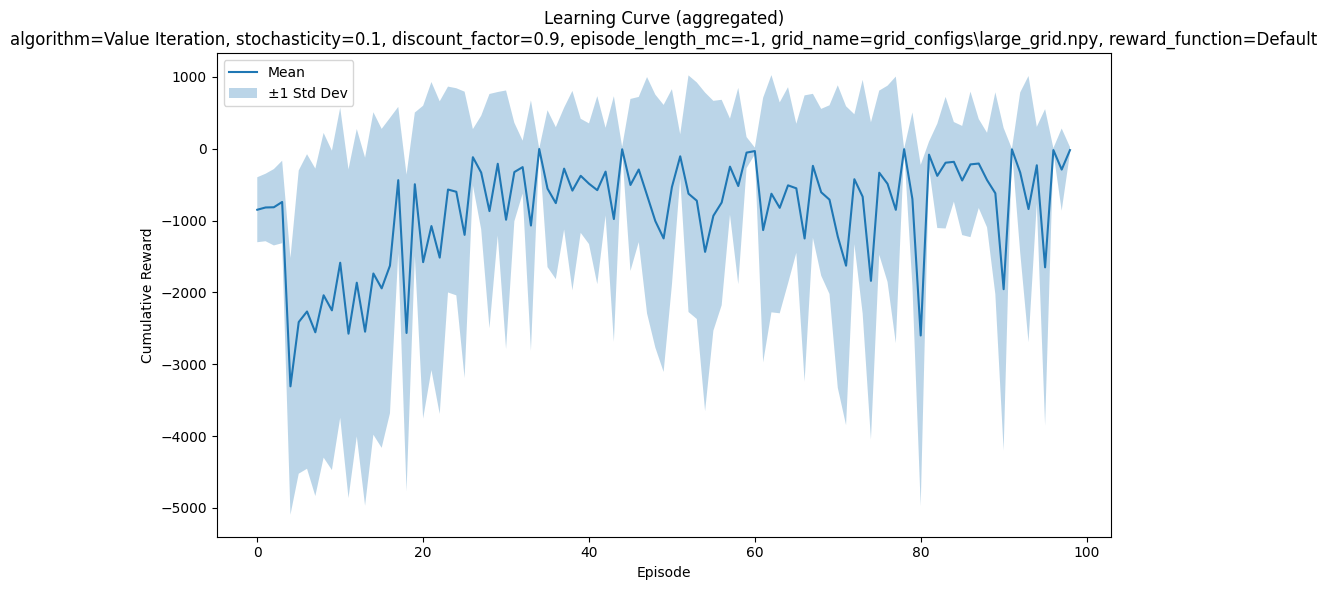

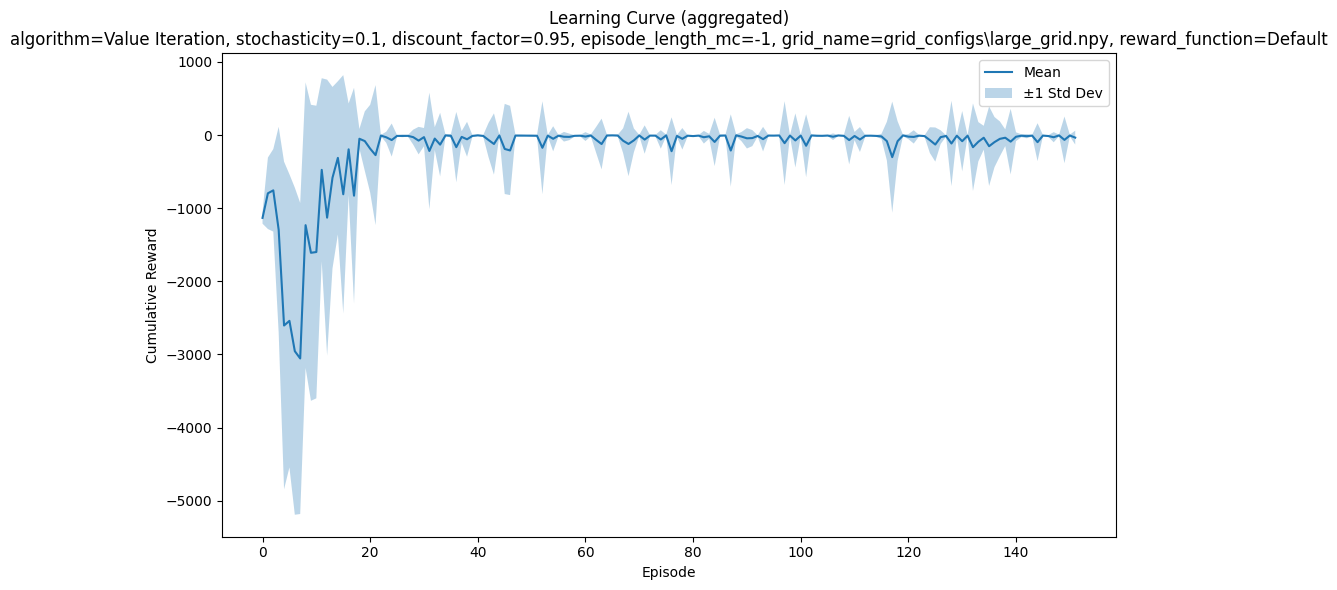

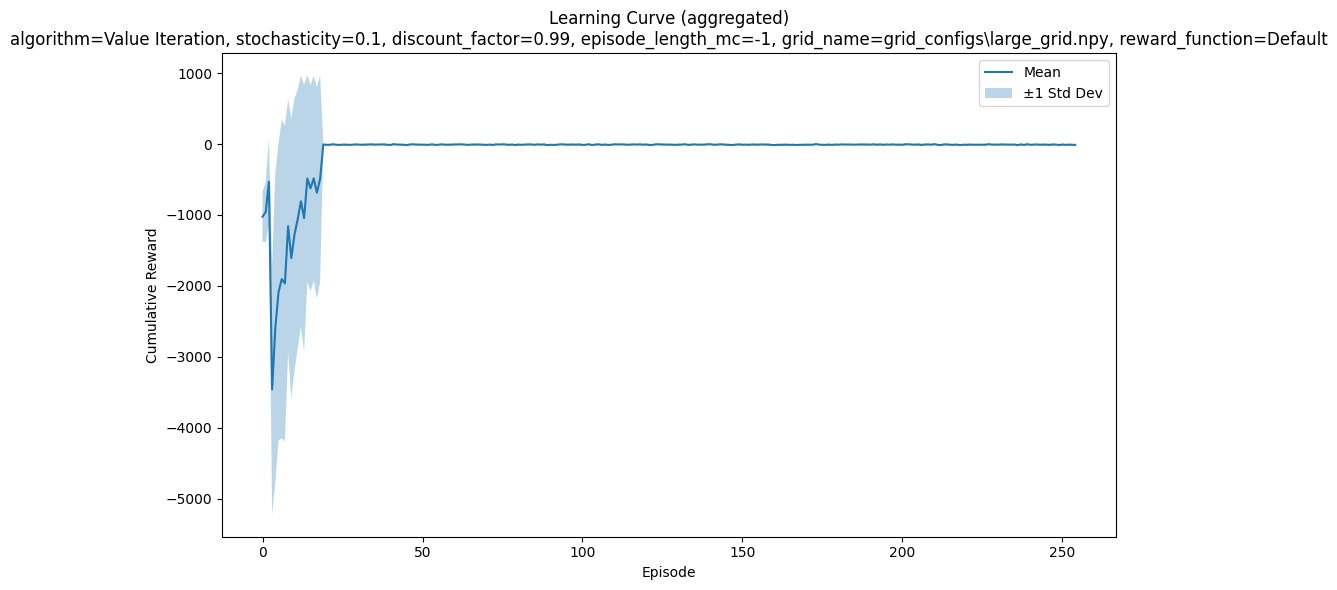

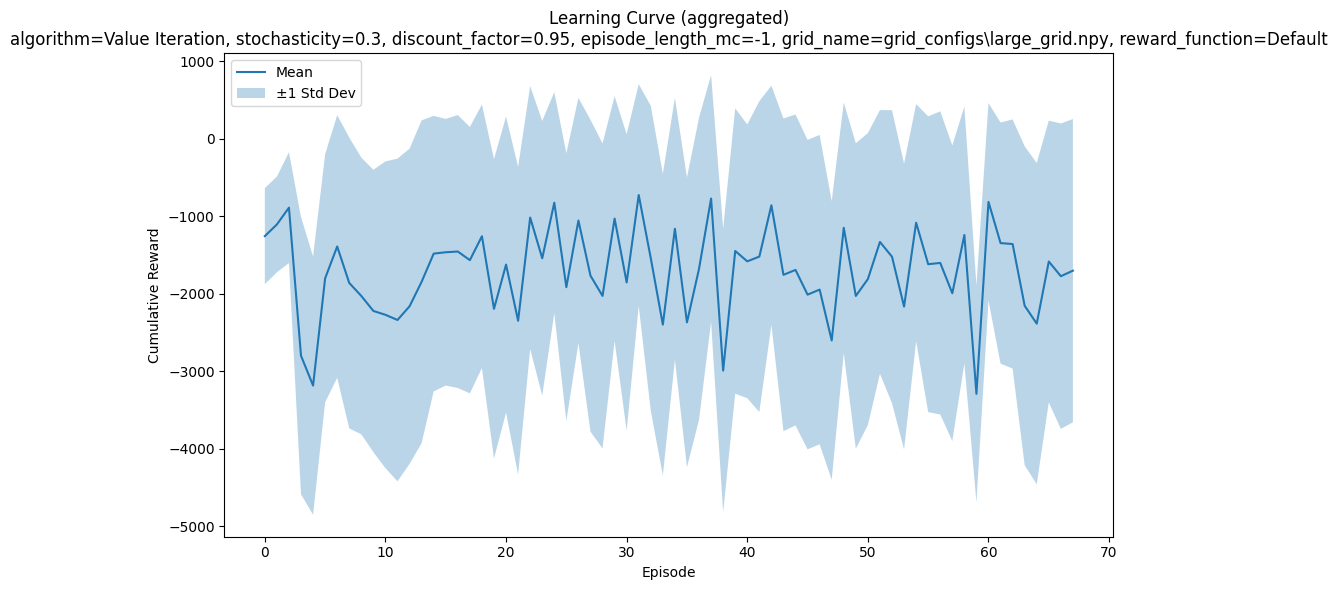

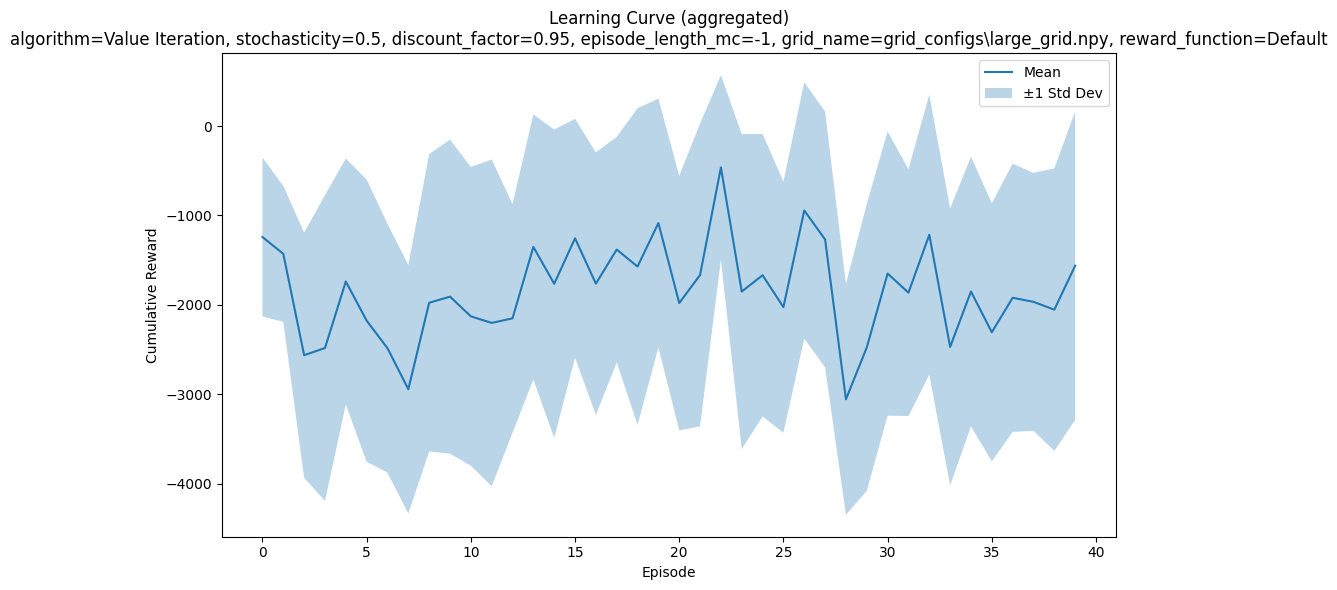

In [5]:
# Graph generated using ChatGPT:
# https://chatgpt.com/share/681dc499-9e24-8001-93b2-1d11e7a01f58

# 3) Aggregate: only group on the *static* hyper‑params, not on epsilon
param_cols = [
    'algorithm',
    'stochasticity',
    'discount_factor',
    'episode_length_mc',
    'grid_name',
    'reward_function'
]

agg_plots = {}
for params, grp in df.groupby(param_cols):
    # pivot: index=episode, columns=run_id, values=cumulative_reward
    wide = grp.pivot_table(
        index='episode',
        columns='run_id',
        values='cumulative_reward'
    ).sort_index()

    # skip any tiny groups just in case
    if wide.shape[1] < 2:
        continue

    agg_plots[params] = wide

# 4) Plot mean ± std for each parameter‑set
for params, wide in agg_plots.items():
    mean_series = wide.mean(axis=1)
    std_series  = wide.std(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_series.index, mean_series, label='Mean')
    plt.fill_between(
        mean_series.index,
        mean_series - std_series,
        mean_series + std_series,
        alpha=0.3,
        label='±1 Std Dev'
    )

    param_str = ', '.join(f'{k}={v}' for k, v in zip(param_cols, params))
    plt.title(f'Learning Curve (aggregated)\n{param_str}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
# deduce the standard values for the hyper-parameters
stable_parameters = [
    'stochasticity',
    'discount_factor',
    'episode_length_mc',
]

variable_parameters = [
    'learning_rate',
    'epsilon',
]

# the default values for the hyper-parameters
for param in stable_parameters:
    default_value = df[param].mode()[0]
    print(f"{param}: {default_value}")

for param in variable_parameters:
    default_value = df[param].mode()[0]
    print(f"{param}: {default_value}")

stochasticity: 0.1
discount_factor: 0.95
episode_length_mc: 500
learning_rate: 0.0099986715932718
epsilon: -1.0


In [7]:
df['stochasticity'].unique()

array([0. , 0.1, 0.3, 0.5])

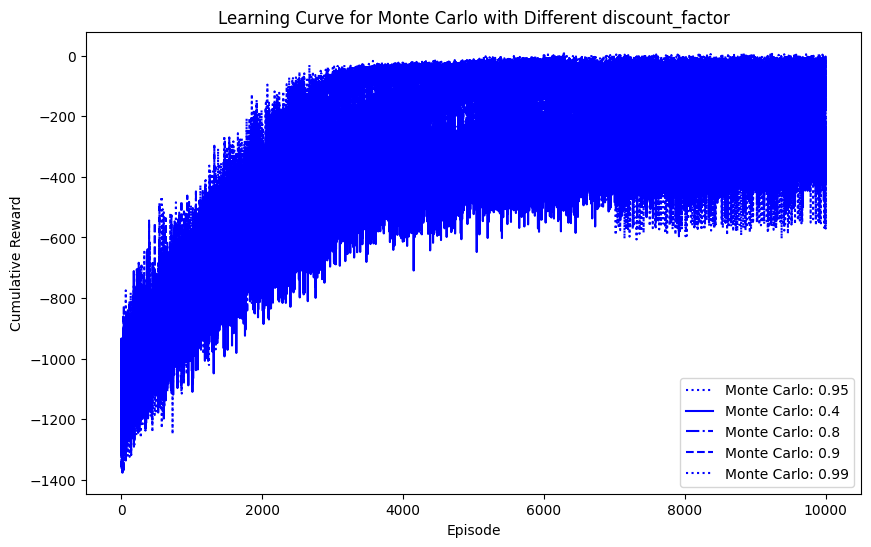

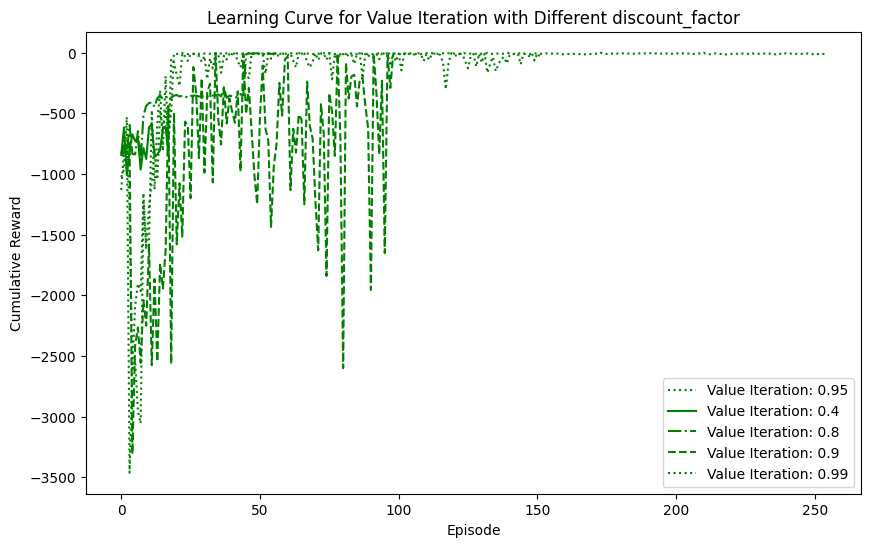

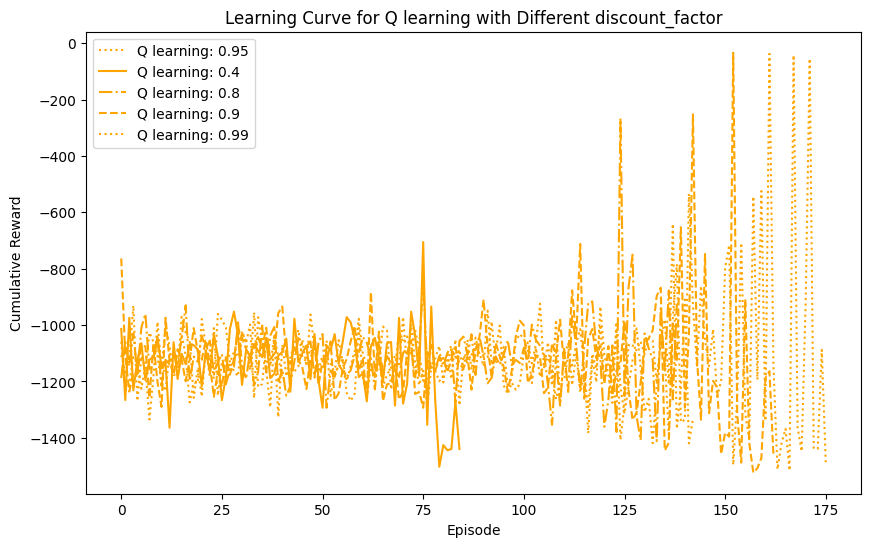

In [8]:
parameter = 'discount_factor'  # or 'stochasticity'

# create a map from algorithm to its corresponding color
colors = {
    'Value Iteration': 'green',
    'Monte Carlo': 'blue',
    'Q learning': 'orange'
}

# and from stochasticity to a line style
line_styles = {
    '0.0': '-', 
    '0.1': '--',
    '0.4': '-',
    '0.8': '-.',
    '0.9': '--',
    '0.95': ':',
    '0.99': ':',
}



for algorithm in df['algorithm'].unique():
    plt.figure(figsize=(10, 6))
    for param_value in df[parameter].unique():
        # filter the dataframe for the current algorithm and parameter value, while keeping all other parameters equal to their default values
        filtered_df = df[
            (df['algorithm'] == algorithm) &
            (df[parameter] == param_value)
        ]
        # filter out the default values for the other parameters
        for param in stable_parameters:
            if param != parameter:
                default_value = df[param].mode()[0]
                filtered_df = filtered_df[
                    (filtered_df[param] == default_value) |
                    (filtered_df[param] == -1)
                    ]
        # check if the filtered dataframe is empty
        if filtered_df.empty:
            print(f"No data for {algorithm} with {parameter}={param_value}")
            continue

        # plot the mean and std deviation over the runs
        mean_series = filtered_df.groupby('episode')['cumulative_reward'].mean()
        std_series = filtered_df.groupby('episode')['cumulative_reward'].std()
        plt.plot(mean_series.index, mean_series, label=f'{algorithm}: {param_value}', color=colors[algorithm], linestyle=line_styles[str(param_value)])
        # plt.fill_between(
        #     mean_series.index,
        #     mean_series - std_series,
        #     mean_series + std_series,
        #     alpha=0.3,
        #     color=colors[algorithm],
        # )
        plt.title(f'Learning Curve for {algorithm} with Different {parameter}')

    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title(f'Learning Curve for {algorithm} with Different {parameter}')
    plt.legend()
    plt.show()


# Convergence metric

In [9]:
df2 = pd.read_csv("results.csv", sep=",")

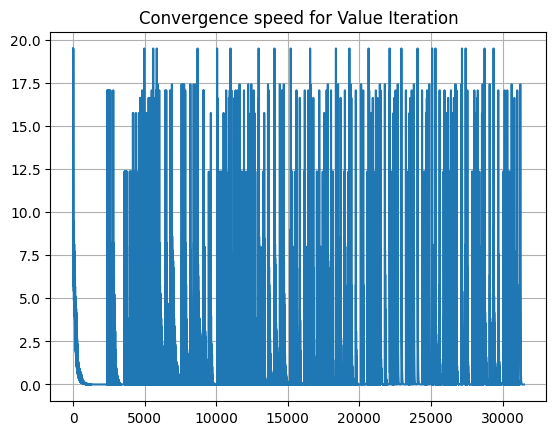

In [10]:
plt.plot(df2[df2["algorithm"]=="Value Iteration"].reset_index()['conv_metricV']);
plt.title("Convergence speed for Value Iteration")
plt.grid()

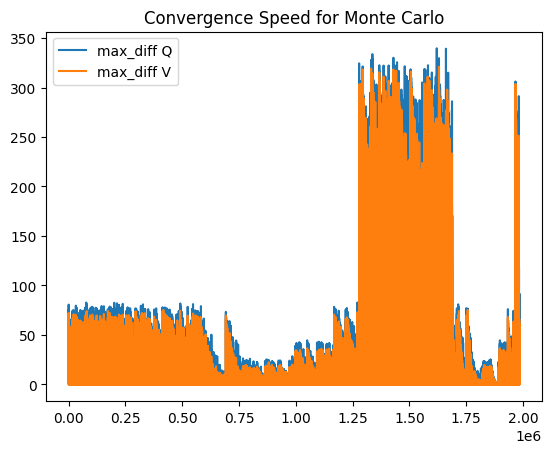

In [11]:
plt.plot(df2.query("algorithm=='Monte Carlo'")['conv_metricQ'], label="max_diff Q");
plt.plot(df2.query("algorithm=='Monte Carlo'")['conv_metricV'], label="max_diff V");
plt.title("Convergence Speed for Monte Carlo")
plt.legend();

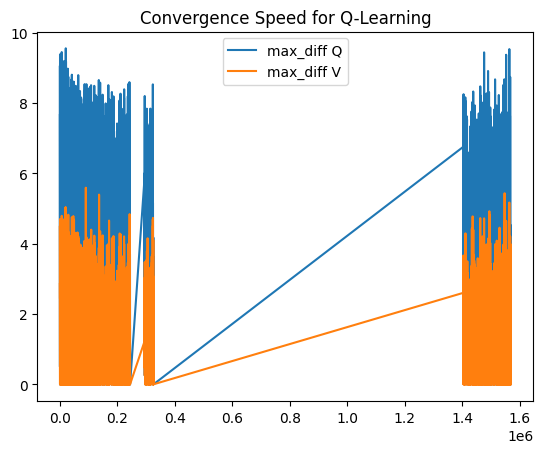

In [12]:
plt.plot(df2.query("algorithm=='Q learning'")['conv_metricQ'], label="max_diff Q");
plt.plot(df2.query("algorithm=='Q learning'")['conv_metricV'], label="max_diff V");
plt.title("Convergence Speed for Q-Learning")
plt.legend();

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Used claude.ai to quickly iteration on and improve the function

def create_algorithm_comparison_plots(df, x_param, x_values, algorithms, 
                                     title, x_label, fixed_params=None,
                                     colors=None, figsize=(15, 3),
                                     use_log_scale=True, save_path=None,
                                     conv_threshold=0.01, percentile_range=75):
    """
    Create comparison plots for different algorithms across varying parameter values.
    With reduced error bands showing only up to the specified percentile range.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The data with algorithm results
    x_param : str
        The parameter name to vary on x-axis
    x_values : list
        The values of the parameter to plot
    algorithms : list
        List of algorithm names to compare
    title : str
        The main title for the figure
    x_label : str
        Label for the x-axis
    fixed_params : dict, optional
        Dictionary of parameters to hold constant {param_name: value}
    colors : list, optional
        List of colors for each algorithm
    figsize : tuple, optional
        Figure size (width, height)
    use_log_scale : bool, optional
        Whether to use log scale for convergence plot
    save_path : str, optional
        Path to save the figure
    conv_threshold : float, optional
        Threshold for convergence (delta V)
    percentile_range : int, optional
        Percentile range to show in error bands (e.g., 75 for 75th percentile)
    
    Returns:
    --------
    fig : matplotlib Figure
        The created figure object
    """
    if colors is None:
        colors = ['blue', 'red', 'green']
    
    if fixed_params is None:
        fixed_params = {}
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axis_label_fontsize = 14
    subplot_title_fontsize = 18
    
    axes[0].set_title(f"Convergence Speed (Threshold = {conv_threshold})", fontsize=subplot_title_fontsize)
    axes[0].set_xlabel(x_label, fontsize=axis_label_fontsize)
    axes[0].set_ylabel("Iterations to Converge", fontsize=axis_label_fontsize)
    if use_log_scale:
        axes[0].set_yscale('log')
    
    axes[1].set_title("Final Policy Quality", fontsize=subplot_title_fontsize)
    axes[1].set_xlabel(x_label, fontsize=axis_label_fontsize)
    axes[1].set_ylabel("Cumulative Reward", fontsize=axis_label_fontsize)
    
    # Define percentile calculation for error bands
    def get_percentile_bounds(data):        
        lower_percentile = np.percentile(data, (100 - percentile_range))
        upper_percentile = np.percentile(data, percentile_range)
        
        return lower_percentile, upper_percentile
    
    for i, alg in enumerate(algorithms):
        conv_speeds_by_param = []
        rewards_by_param = []
        conv_speeds_lower = []
        conv_speeds_upper = []
        rewards_lower = []
        rewards_upper = []
        
        for param_value in x_values:
            # Create filter conditions
            filter_conditions = {
                "algorithm": alg,
                x_param: param_value
            }
            filter_conditions.update(fixed_params)
            
            # Apply filters
            subset = df.copy()
            for key, value in filter_conditions.items():
                subset = subset[subset[key] == value]
            
            conv_speed_results = []
            reward_results = []
            
            for _, group in subset.groupby('run_id'):
                # Find first iteration/episode where convergence threshold is met
                conv_rows = group[group['conv_metricV'] <= conv_threshold]
                
                if len(conv_rows) > 0:
                    # Get the first row where threshold is met
                    first_conv_row = conv_rows.iloc[0]
                    
                    # Get the iteration/episode where convergence occurred
                    if alg == "Value Iteration":
                        conv_speed = first_conv_row['step']
                    else: 
                        conv_speed = first_conv_row['episode']
                        
                    conv_speed_results.append(conv_speed)
                else:
                    # If never converged, use max iterations/episodes
                    if alg == "Value Iteration":
                        max_iter = group['step'].max()
                    else:
                        max_iter = group['episode'].max()
                    conv_speed_results.append(max_iter)
                
                if len(group) > 0:
                    final_reward = group['cumulative_reward'].iloc[-1]
                    reward_results.append(final_reward)
            
            # Calculate statistics
            if conv_speed_results:
                conv_speeds_by_param.append(np.mean(conv_speed_results))
                lower, upper = get_percentile_bounds(conv_speed_results)
                conv_speeds_lower.append(lower)
                conv_speeds_upper.append(upper)
            else:
                conv_speeds_by_param.append(np.nan)
                conv_speeds_lower.append(np.nan)
                conv_speeds_upper.append(np.nan)
                
            if reward_results:
                rewards_by_param.append(np.mean(reward_results))
                lower, upper = get_percentile_bounds(reward_results)
                rewards_lower.append(lower)
                rewards_upper.append(upper)
            else:
                rewards_by_param.append(np.nan)
                rewards_lower.append(np.nan)
                rewards_upper.append(np.nan)
        
        color = colors[i % len(colors)]
        axes[0].plot(x_values, conv_speeds_by_param, 'o-', color=color, label=alg)
        axes[1].plot(x_values, rewards_by_param, 'o-', color=color, label=alg)
        
        # Add reduced error bands using percentile range
        axes[0].fill_between(x_values, conv_speeds_lower, conv_speeds_upper, 
                             color=color, alpha=0.2)
        
        axes[1].fill_between(x_values, rewards_lower, rewards_upper, 
                             color=color, alpha=0.2)
    
    # Place legend in the upper right of both plots
    axes[0].legend(loc='best')
    axes[1].legend(loc='best')
    
    axes[0].grid(True, alpha=0.3)
    axes[1].grid(True, alpha=0.3)
    
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return fig

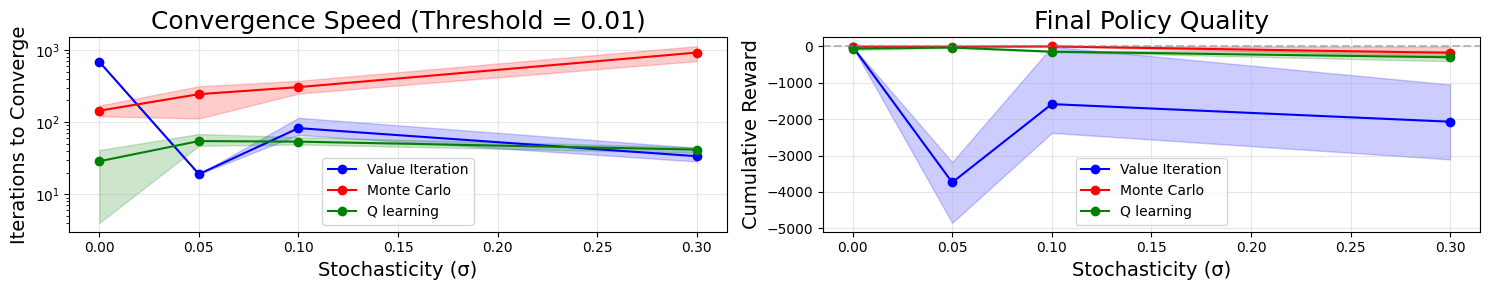

In [ ]:
df = pd.read_csv("results_FIN_SIGMA.csv", sep=",")
algorithms = ["Value Iteration", "Monte Carlo", "Q learning"]

stochasticity_values = [0.0, 0.05, 0.1, 0.3]
fig1 = create_algorithm_comparison_plots(
    df=df,
    x_param="stochasticity",
    x_values=stochasticity_values,
    algorithms=algorithms,
    title="Effect of Stochasticity (σ) on Algorithm Performance",
    x_label="Stochasticity (σ)",
    fixed_params={"discount_factor": 0.99},
    save_path="sigma_comparison.svg"
)

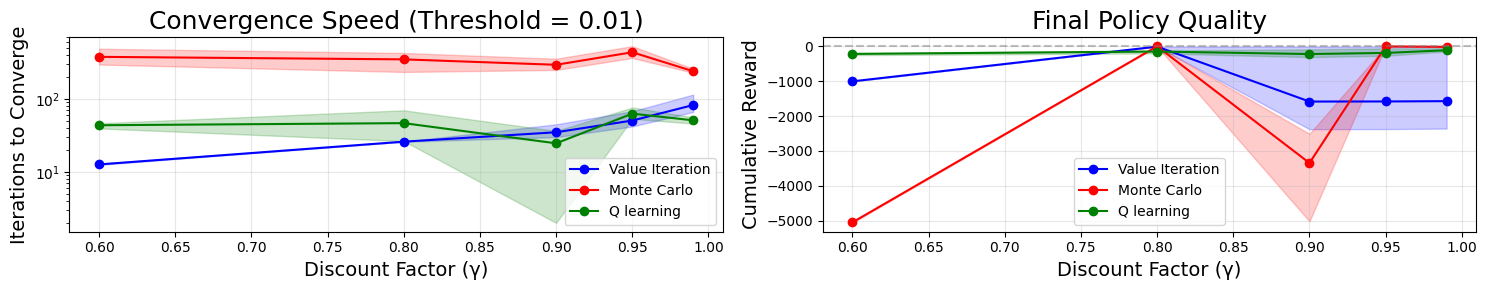

In [26]:
df = pd.read_csv("results_FIN_GAMMA.csv", sep=",")
algorithms = ["Value Iteration", "Monte Carlo", "Q learning"]

gamma_values = [0.6, 0.8, 0.9, 0.95, 0.99]
fig2 = create_algorithm_comparison_plots(
    df=df,
    x_param="discount_factor",
    x_values=gamma_values,
    algorithms=algorithms,
    title="Effect of Discount Factor (γ) on Algorithm Performance",
    x_label="Discount Factor (γ)",
    fixed_params={"stochasticity": 0.1},
    save_path="gamma_comparison.svg"
)

plt.show()

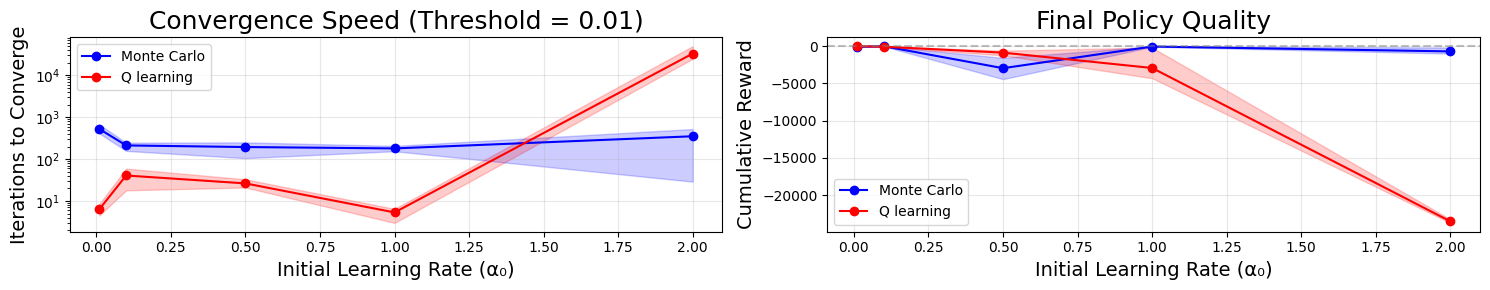

In [27]:
df = pd.read_csv("results_FIN_ALPHA.csv", sep=",")
algorithms = ["Monte Carlo", "Q learning"]

initial_alpha = [0.01, 0.1, 0.5, 1, 2]

fig1 = create_algorithm_comparison_plots(
    df=df,
    x_param="initial_alpha",
    x_values=initial_alpha,
    algorithms=algorithms,
    title="Effect of Initial Learning Rate (α₀) on Performance",
    x_label="Initial Learning Rate (α₀)",
    fixed_params=None,
    save_path="alpha_comparison.svg",
    use_log_scale=True
)

plt.show()

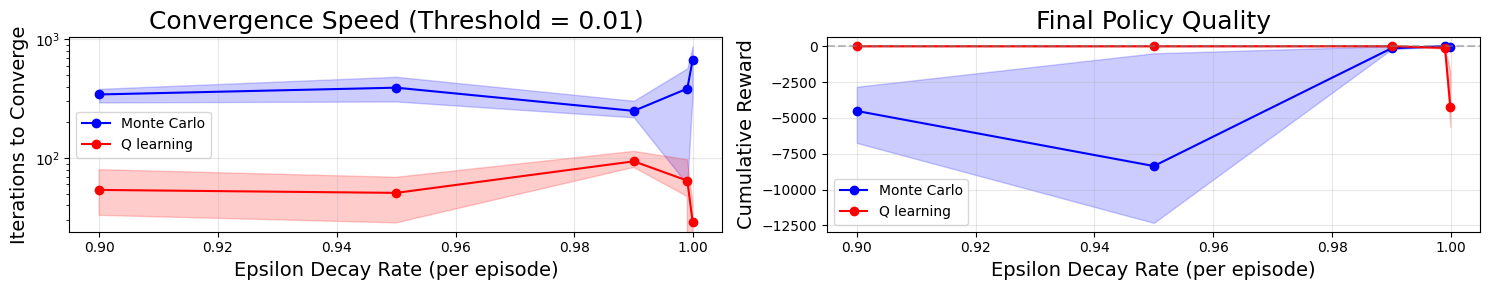

In [28]:
df = pd.read_csv("results_FIN_EPSILON.csv", sep=",")
algorithms = ["Monte Carlo", "Q learning"]

epsilon_decay = [0.9, 0.95, 0.99, 0.999, 0.9999]

fig1 = create_algorithm_comparison_plots(
    df=df,
    x_param="epsilon_decay",
    x_values=epsilon_decay,
    algorithms=algorithms,
    title="Effect of Epsilon Decay Rate (ε-decay) on Performance",
    x_label="Epsilon Decay Rate (per episode)",
    fixed_params=None,
    save_path="epsilon_comparison.svg",
    use_log_scale=True
)

plt.show()

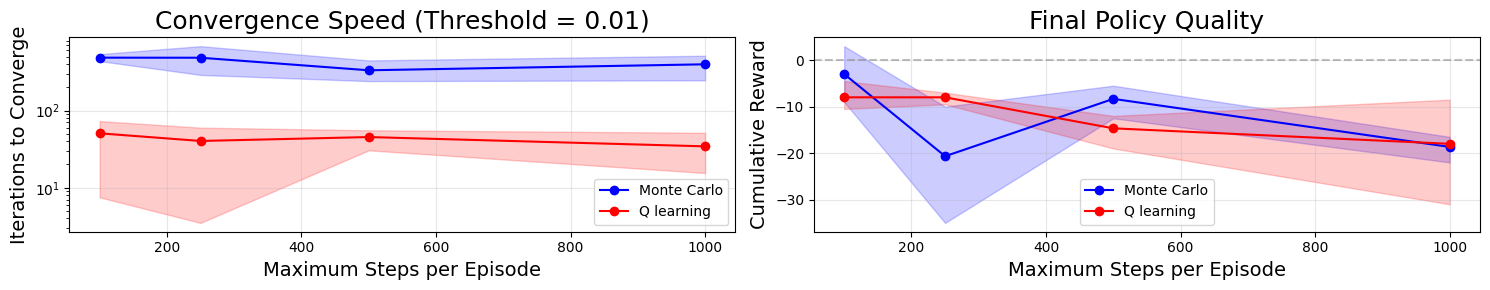

In [30]:
df = pd.read_csv("results_FIN_MAX_STEPS.csv", sep=",")
algorithms = ["Monte Carlo", "Q learning"]

max_steps_per_episode = [100, 250, 500, 1000]

fig1 = create_algorithm_comparison_plots(
    df=df,
    x_param="episode_length_mc",
    x_values=max_steps_per_episode,
    algorithms=algorithms,
    title="Effect of Epsilon Decay Rate (ε-decay) on Performance",
    x_label="Maximum Steps per Episode",
    fixed_params=None,
    save_path="episode_length_comparison.svg",
    use_log_scale=True
)

plt.show()